In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import SimpleRNN , Input,Flatten, LSTM
from tensorflow.keras import backend as K
from keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

2024-12-07 14:51:31.483864: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-07 14:51:31.487587: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-07 14:51:31.497724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733611891.514466 1356306 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733611891.519468 1356306 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 14:51:31.538073: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
opened = []

csv_path = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CSV/'

masterlist = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/ALL_STATIONS_FINAL_REVISED3.csv'

stations_df = pd.read_csv(masterlist)
station_num = stations_df['grdc_no']

arrayFile = [os.path.join(csv_path, f"{station_no}.csv") for station_no in station_num]

for file in arrayFile:
  df = pd.read_csv(file, index_col= None, header = 0)
  opened.append(df)

total_df = pd.concat(opened, axis = 0, ignore_index = True)

q = total_df['Q']
print(min(q),max(q))
swe = total_df['SWE']
scaled = total_df['SWE_scaled']/100
print(min(scaled),max(scaled))

0.0 58699.435
0.0 319504.21638280054


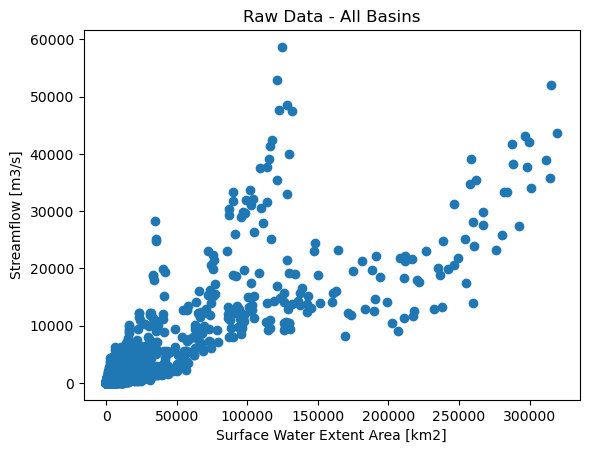

In [3]:
plt.scatter(scaled,q)
plt.title('Raw Data - All Basins')
plt.xlabel('Surface Water Extent Area [km2]')
plt.ylabel('Streamflow [m3/s]')
# plt.savefig('global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rawdata.png')
plt.show()

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU

# Convert q and swe to NumPy arrays
X = scaled.to_numpy()  # This will be 1D: shape (num_samples,)
y = q.to_numpy()

# Assume X and y are your 1D time series arrays
# Step 1: Replace zeros with a small value
X[X == 0] = 1e-9
y[y == 0] = 1e-9

# Step 2: Reshape data (if needed)
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

# Step 3: Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [5]:
# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Nadam
from tensorflow.keras.losses import Huber

# Define the model
model = Sequential([
    Dense(512, input_dim=1, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    # Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Linear activation for regression
])


# Compile the model
model.compile(optimizer=Nadam(learning_rate=1e-3), loss=Huber(delta=0.1), metrics=['mae'])

# Define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=150,  # High epochs with early stopping
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler]
)

Epoch 1/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.5324e-04 - mae: 0.0115 - val_loss: 5.5766e-04 - val_mae: 0.0164 - learning_rate: 0.0010
Epoch 2/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.8773e-04 - mae: 0.0109 - val_loss: 3.7044e-04 - val_mae: 0.0103 - learning_rate: 0.0010
Epoch 3/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5701e-04 - mae: 0.0101 - val_loss: 3.5955e-04 - val_mae: 0.0133 - learning_rate: 0.0010
Epoch 4/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.3980e-04 - mae: 0.0107 - val_loss: 3.5913e-04 - val_mae: 0.0104 - learning_rate: 0.0010
Epoch 5/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.8145e-04 - mae: 0.0103 - val_loss: 3.5264e-04 - val_mae: 0.0092 - learning_rate: 0.0010
Epoch 6/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.0955e-04 - mae: 0.0092 - val_loss: 3.6021e-04 - val_mae: 0.0108 - learning_rate: 0.0010
Epoch 7/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.7385e-04 - mae: 0.0118 - val_lo

In [16]:
# Step 7: Evaluate
test_loss = model.evaluate(X_test, y_test)
print(f"Test MAPE: {test_loss}")

# Step 8: Predict
predictions = model.predict(X_test)
y_pred = scaler_y.inverse_transform(predictions)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9455e-04 - mae: 0.0092
Test MAPE: [0.000311379786580801, 0.008944740518927574]
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


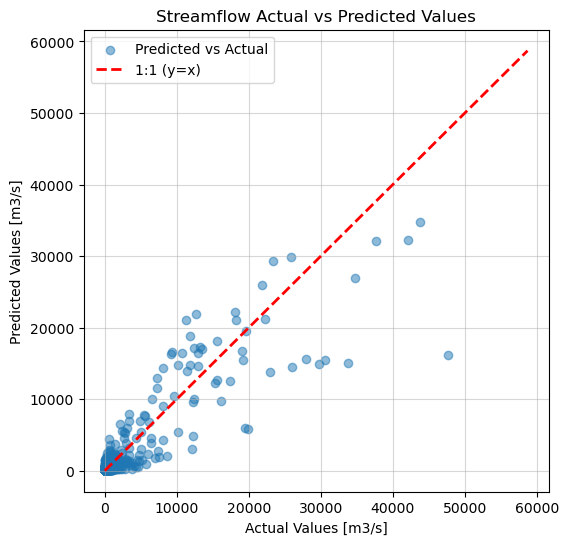

In [17]:
# Step 1: Predict values
y_pred = model.predict(X_test)

# Step 2: Create the scatter plotD
plt.figure(figsize=(6,6))
plt.scatter(y_test*max(y), y_pred*max(y), alpha=0.5, label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 (y=x)', linewidth=2)

# Step 3: Add labels, title, and legend
plt.title("Streamflow Actual vs Predicted Values")
plt.xlabel("Actual Values [m3/s]")
plt.ylabel("Predicted Values [m3/s]")
plt.legend()
plt.grid(alpha=0.5)

# Step 4: Show the plot
plt.show()

Mean Squared Error (MSE): 0.0008772928189313531


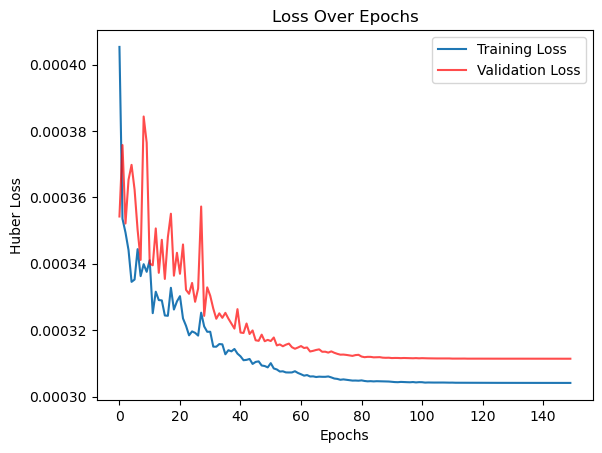

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Compute MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# print((max(y_train) - min(y_train))**2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss',color='r',alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Huber Loss')
plt.title('Loss Over Epochs')
# plt.ylim(0.00006, 0.0002)
plt.legend()
plt.show()


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


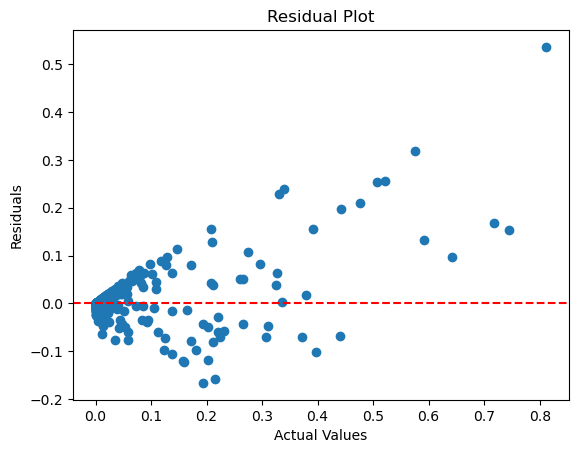

In [19]:
import matplotlib.pyplot as plt

residuals = y_test - model.predict(X_test)
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


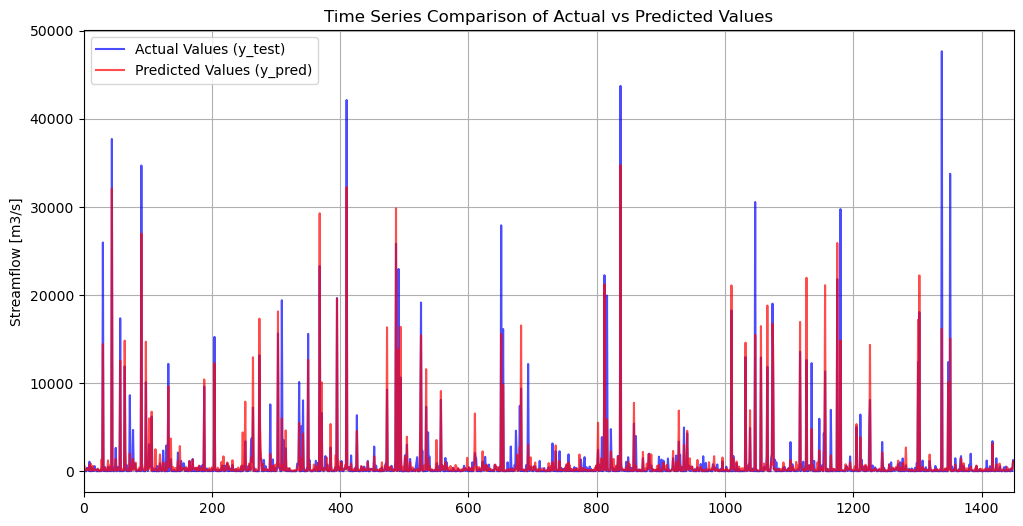

In [20]:
# Plot y_test and y_pred as a time series
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test)), y_test*max(y), label="Actual Values (y_test)", color="blue", alpha=0.7)
plt.plot(np.arange(len(y_pred)), y_pred*max(y), label="Predicted Values (y_pred)", color="red", alpha=0.7)
plt.title("Time Series Comparison of Actual vs Predicted Values")
# plt.xlabel("Time Step")
plt.ylabel("Streamflow [m3/s]")
plt.xlim(0,len(y_test))
plt.legend()
plt.grid(True)
plt.show()

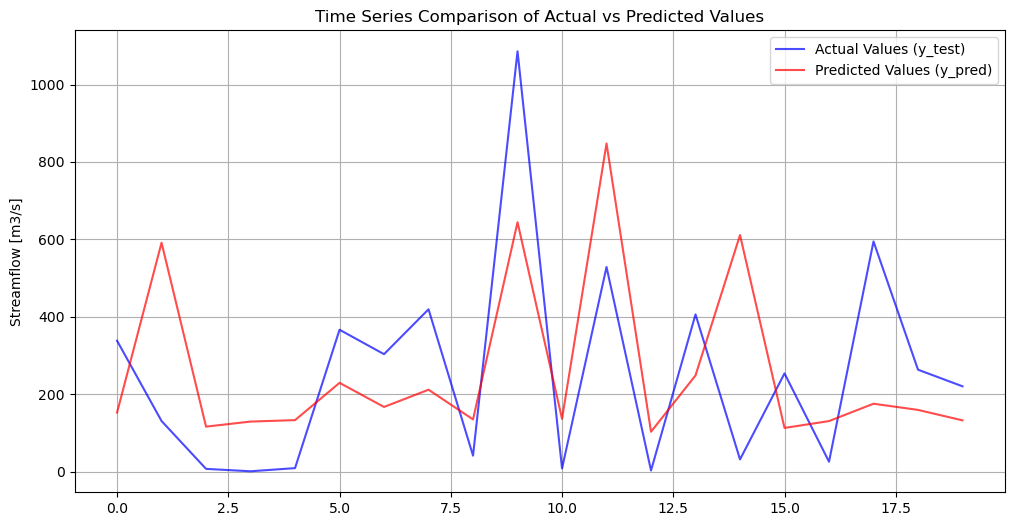

In [12]:
# Plot y_test and y_pred as a time series
plt.figure(figsize=(12, 6))
plt.plot((np.arange(len(y_test)))[0:20], (y_test*max(y))[0:20], label="Actual Values (y_test)", color="blue", alpha=0.7)
plt.plot((np.arange(len(y_pred)))[0:20], (y_pred*max(y))[0:20], label="Predicted Values (y_pred)", color="red", alpha=0.7)

# Add titles and labels
plt.title("Time Series Comparison of Actual vs Predicted Values")
# plt.xlabel("Time Step")
plt.ylabel("Streamflow [m3/s]")
# plt.xlim(0,len(y_test))
plt.legend()
plt.grid(True)
plt.show()

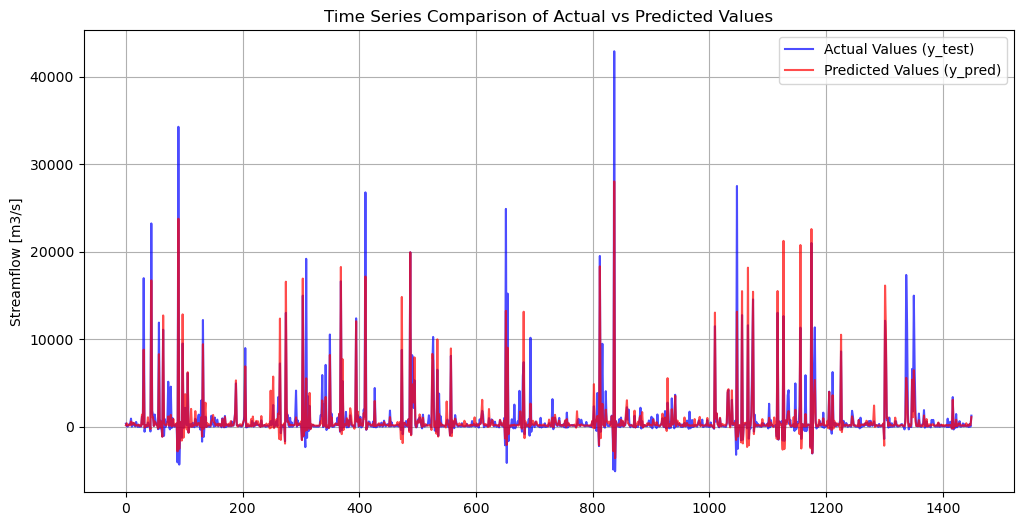

In [13]:
from scipy.interpolate import make_interp_spline

xnew_test = np.arange(len(y_test))
ynew_test = y_test*max(y)
xnew_pred = np.arange(len(y_pred))
ynew_pred = y_pred*max(y)
X_Y_Spline_Test = make_interp_spline(xnew_test, ynew_test)
X_Y_Spline_Pred = make_interp_spline(xnew_pred, ynew_pred)
# Returns evenly spaced numbers
# over a specified interval.
X_1 = np.linspace(0, xnew_test.max(), 1000)
Y_1 = X_Y_Spline_Test(X_1)
X_2 = np.linspace(0, xnew_pred.max(), 1000)
Y_2 = X_Y_Spline_Pred(X_2)

# Plot y_test and y_pred as a time series
plt.figure(figsize=(12, 6))
plt.plot(X_1,Y_1, label="Actual Values (y_test)", color="blue", alpha=0.7)
plt.plot(X_2,Y_2, label="Predicted Values (y_pred)", color="red", alpha=0.7)


# Add titles and labels
plt.title("Time Series Comparison of Actual vs Predicted Values")
# plt.xlabel("Time Step")
plt.ylabel("Streamflow [m3/s]")
# plt.xlim(0,len(y_test))
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# filename = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CNN/rnn_plot.png'
# # Ensure the directory exists
# os.makedirs(os.path.dirname(filename), exist_ok=True)
# from tensorflow.keras.utils import plot_model

# # Plot and save the model
# plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True)

# from IPython.display import Image
# Image(filename)